# AUROC 데이터 시각화

이 노트북은 logs/train_logs 폴더의 AUROC 데이터를 시각화합니다.


In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
import glob

from common.config import setup_korean_font

# 한글 폰트 설정
setup_korean_font()

# 클래스 이름 매핑 (한글)
CLASS_NAMES = {
    0: "광선각화증",
    1: "기저세포암",
    2: "멜라닌세포모반",
    3: "보웬병",
    4: "비립종",
    5: "사마귀",
    6: "악성흑색종",
    7: "지루각화증",
    8: "편평세포암",
    9: "표피낭종",
    10: "피부섬유종",
    11: "피지샘증식증",
    12: "혈관종",
    13: "화농 육아종",
    14: "흑색점",
}

한글 폰트 설정 완료 : AppleGothic


In [17]:
def load_auroc_data(data_dir):
    """AUROC 데이터 로드"""
    train_data = {}
    val_data = {}

    # Train 데이터 로드
    train_files = glob.glob(os.path.join(data_dir, "train_auroc_data_epoch_*.json"))
    for file_path in sorted(train_files):
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            epoch = data["epoch"]
            train_data[epoch] = {
                "outputs": np.array(data["outputs"]),
                "labels": np.array(data["labels"]),
            }

    # Validation 데이터 로드
    val_files = glob.glob(os.path.join(data_dir, "val_auroc_data_epoch_*.json"))
    for file_path in sorted(val_files):
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            epoch = data["epoch"]
            val_data[epoch] = {
                "outputs": np.array(data["outputs"]),
                "labels": np.array(data["labels"]),
            }

    return train_data, val_data


def calculate_auroc_per_class(outputs, labels, num_classes=15):
    """클래스별 AUROC 계산"""
    auroc_scores = {}

    for i in range(num_classes):
        try:
            # i번째 클래스에 대한 이진 분류로 변환
            binary_labels = (labels == i).astype(int)
            binary_outputs = outputs[:, i]

            if len(np.unique(binary_labels)) > 1:  # 클래스가 하나만 있으면 계산 불가
                fpr, tpr, _ = roc_curve(binary_labels, binary_outputs)
                auroc = auc(fpr, tpr)
                auroc_scores[i] = auroc
            else:
                auroc_scores[i] = 0.0
        except:
            auroc_scores[i] = 0.0

    return auroc_scores

In [18]:
# 데이터 로드
data_dir = "logs/train_logs"
train_data, val_data = load_auroc_data(data_dir)

print(f"Loaded data for epochs: {sorted(train_data.keys())}")
print(f"Train data shape: {train_data[1]['outputs'].shape}")
print(f"Val data shape: {val_data[1]['outputs'].shape}")


Loaded data for epochs: [1, 2, 3, 4, 5]
Train data shape: (12000, 15)
Val data shape: (1500, 15)


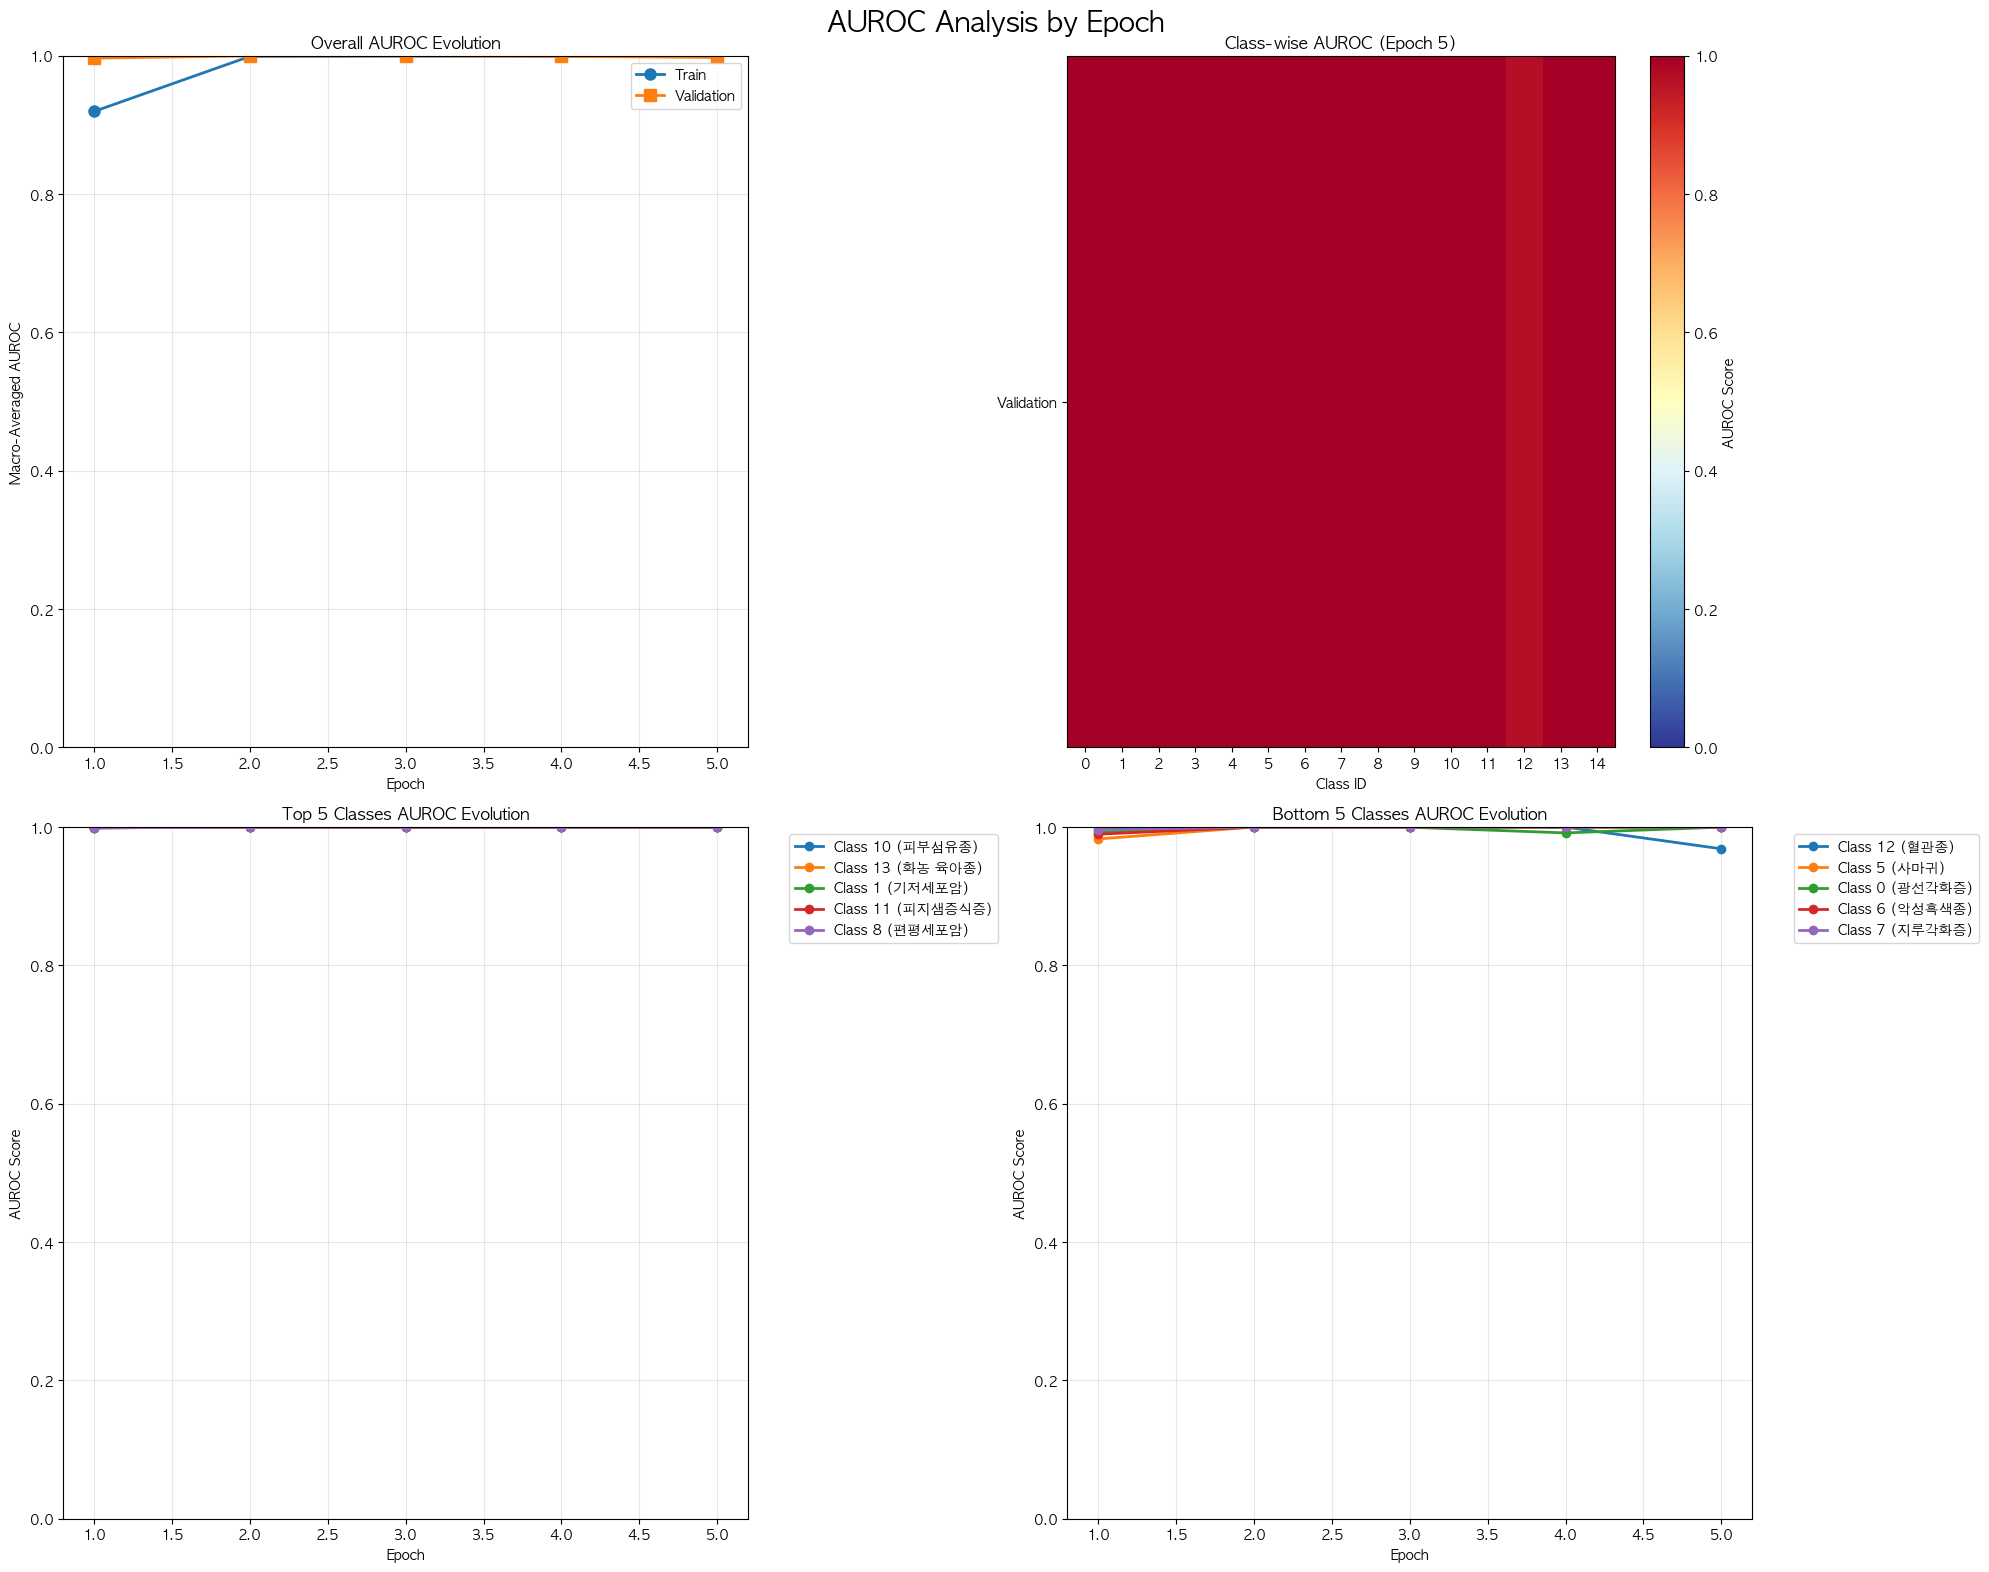

In [19]:
# 1. 에포크별 AUROC 변화 시각화
epochs = sorted(train_data.keys())
    
# 클래스별 AUROC 계산
train_aurocs = defaultdict(list)
val_aurocs = defaultdict(list)

for epoch in epochs:
    train_auroc_scores = calculate_auroc_per_class(
        train_data[epoch]['outputs'], 
        train_data[epoch]['labels']
    )
    val_auroc_scores = calculate_auroc_per_class(
        val_data[epoch]['outputs'], 
        val_data[epoch]['labels']
    )
    
    for class_id in range(15):
        train_aurocs[class_id].append(train_auroc_scores[class_id])
        val_aurocs[class_id].append(val_auroc_scores[class_id])

# 전체 AUROC (macro-averaged)
train_macro_aurocs = []
val_macro_aurocs = []

for epoch in epochs:
    train_macro = np.mean([train_aurocs[i][epochs.index(epoch)] for i in range(15)])
    val_macro = np.mean([val_aurocs[i][epochs.index(epoch)] for i in range(15)])
    train_macro_aurocs.append(train_macro)
    val_macro_aurocs.append(val_macro)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('AUROC Analysis by Epoch', fontsize=20, fontweight='bold')

# 1. 전체 AUROC 변화
axes[0, 0].plot(epochs, train_macro_aurocs, 'o-', label='Train', linewidth=2, markersize=8)
axes[0, 0].plot(epochs, val_macro_aurocs, 's-', label='Validation', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Macro-Averaged AUROC')
axes[0, 0].set_title('Overall AUROC Evolution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. 클래스별 AUROC 히트맵 (마지막 에포크)
last_epoch = max(epochs)
class_aurocs = []
for class_id in range(15):
    class_aurocs.append(val_aurocs[class_id][-1])

heatmap_data = np.array(class_aurocs).reshape(1, -1)
im = axes[0, 1].imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
axes[0, 1].set_title(f'Class-wise AUROC (Epoch {last_epoch})')
axes[0, 1].set_xlabel('Class ID')
axes[0, 1].set_xticks(range(15))
axes[0, 1].set_xticklabels([f'{i}' for i in range(15)])
axes[0, 1].set_yticks([0])
axes[0, 1].set_yticklabels(['Validation'])

# 컬러바 추가
cbar = plt.colorbar(im, ax=axes[0, 1])
cbar.set_label('AUROC Score')

# 3. 상위 5개 클래스 AUROC 변화
# 마지막 에포크 기준으로 상위 5개 클래스 선택
class_avg_aurocs = [(i, np.mean([val_aurocs[i][j] for j in range(len(epochs))])) for i in range(15)]
top5_classes = sorted(class_avg_aurocs, key=lambda x: x[1], reverse=True)[:5]

for class_id, _ in top5_classes:
    axes[1, 0].plot(epochs, val_aurocs[class_id], 'o-', 
                    label=f'Class {class_id} ({CLASS_NAMES[class_id]})', 
                    linewidth=2, markersize=6)

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUROC Score')
axes[1, 0].set_title('Top 5 Classes AUROC Evolution')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# 4. 하위 5개 클래스 AUROC 변화
bottom5_classes = sorted(class_avg_aurocs, key=lambda x: x[1])[:5]

for class_id, _ in bottom5_classes:
    axes[1, 1].plot(epochs, val_aurocs[class_id], 'o-', 
                    label=f'Class {class_id} ({CLASS_NAMES[class_id]})', 
                    linewidth=2, markersize=6)

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUROC Score')
axes[1, 1].set_title('Bottom 5 Classes AUROC Evolution')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [20]:
# 2. 클래스별 AUROC 상세 분석
print("=" * 80)
print("AUROC ANALYSIS SUMMARY")
print("=" * 80)

for epoch in epochs:
    train_auroc_scores = calculate_auroc_per_class(
        train_data[epoch]['outputs'], 
        train_data[epoch]['labels']
    )
    val_auroc_scores = calculate_auroc_per_class(
        val_data[epoch]['outputs'], 
        val_data[epoch]['labels']
    )
    
    train_macro = np.mean(list(train_auroc_scores.values()))
    val_macro = np.mean(list(val_auroc_scores.values()))
    
    print(f"\nEpoch {epoch}:")
    print(f"  Train Macro-AUROC:  {train_macro:.4f}")
    print(f"  Val Macro-AUROC:    {val_macro:.4f}")
    
    # 상위 3개 클래스
    sorted_classes = sorted(val_auroc_scores.items(), key=lambda x: x[1], reverse=True)
    print(f"  Top 3 Classes:")
    for i, (class_id, score) in enumerate(sorted_classes[:3]):
        print(f"    {i+1}. Class {class_id} ({CLASS_NAMES[class_id]}): {score:.4f}")
    
    # 하위 3개 클래스
    print(f"  Bottom 3 Classes:")
    for i, (class_id, score) in enumerate(sorted_classes[-3:]):
        print(f"    {i+1}. Class {class_id} ({CLASS_NAMES[class_id]}): {score:.4f}")


AUROC ANALYSIS SUMMARY

Epoch 1:
  Train Macro-AUROC:  0.9197
  Val Macro-AUROC:    0.9967
  Top 3 Classes:
    1. Class 12 (혈관종): 1.0000
    2. Class 10 (피부섬유종): 0.9998
    3. Class 13 (화농 육아종): 0.9998
  Bottom 3 Classes:
    1. Class 0 (광선각화증): 0.9928
    2. Class 6 (악성흑색종): 0.9897
    3. Class 5 (사마귀): 0.9828

Epoch 2:
  Train Macro-AUROC:  0.9992
  Val Macro-AUROC:    0.9999
  Top 3 Classes:
    1. Class 1 (기저세포암): 1.0000
    2. Class 2 (멜라닌세포모반): 1.0000
    3. Class 5 (사마귀): 1.0000
  Bottom 3 Classes:
    1. Class 4 (비립종): 0.9999
    2. Class 3 (보웬병): 0.9998
    3. Class 14 (흑색점): 0.9994

Epoch 3:
  Train Macro-AUROC:  0.9997
  Val Macro-AUROC:    1.0000
  Top 3 Classes:
    1. Class 1 (기저세포암): 1.0000
    2. Class 2 (멜라닌세포모반): 1.0000
    3. Class 3 (보웬병): 1.0000
  Bottom 3 Classes:
    1. Class 13 (화농 육아종): 0.9999
    2. Class 0 (광선각화증): 0.9998
    3. Class 12 (혈관종): 0.9997

Epoch 4:
  Train Macro-AUROC:  0.9996
  Val Macro-AUROC:    0.9993
  Top 3 Classes:
    1. Class 4 (비립종): 1

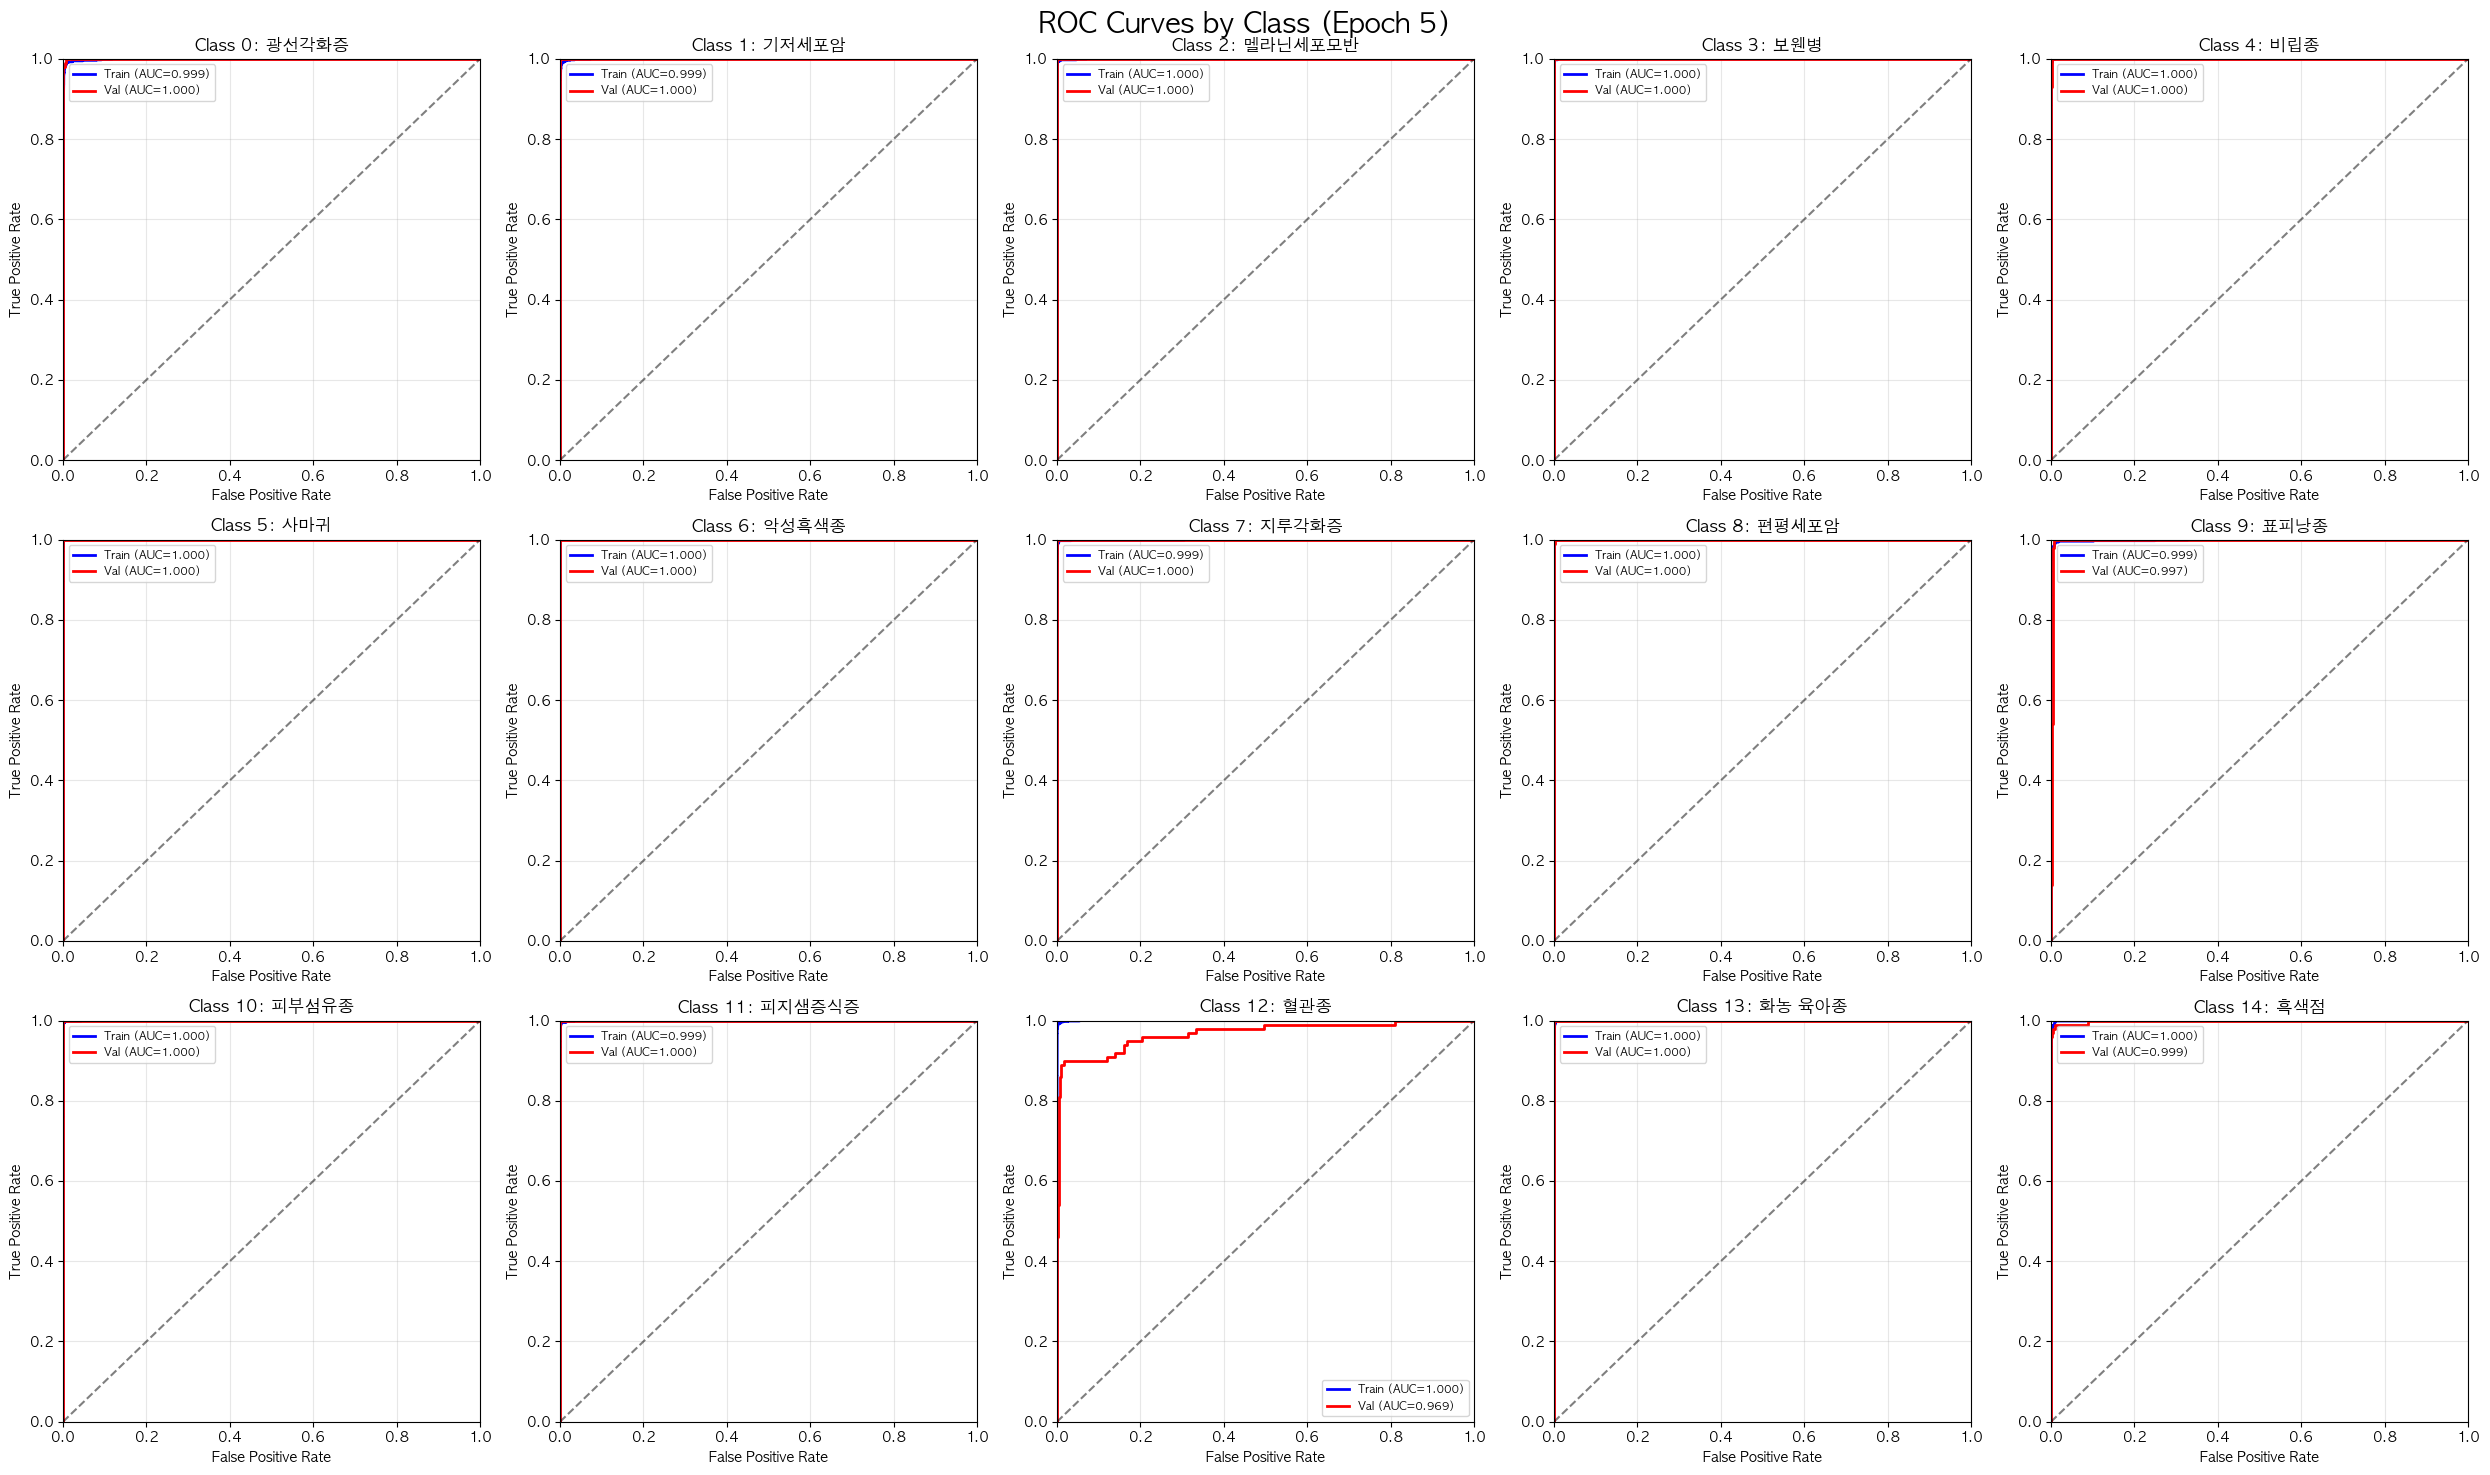

In [21]:
# 4. ROC 곡선 시각화 (마지막 에포크)
last_epoch = max(epochs)
train_outputs = train_data[last_epoch]['outputs']
train_labels = train_data[last_epoch]['labels']
val_outputs = val_data[last_epoch]['outputs']
val_labels = val_data[last_epoch]['labels']

fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle(f'ROC Curves by Class (Epoch {last_epoch})', fontsize=20, fontweight='bold')

for class_id in range(15):
    row = class_id // 5
    col = class_id % 5
    
    # Train ROC
    try:
        binary_labels = (train_labels == class_id).astype(int)
        binary_outputs = train_outputs[:, class_id]
        
        if len(np.unique(binary_labels)) > 1:
            fpr, tpr, _ = roc_curve(binary_labels, binary_outputs)
            train_auroc = auc(fpr, tpr)
            axes[row, col].plot(fpr, tpr, 'b-', linewidth=2, 
                              label=f'Train (AUC={train_auroc:.3f})')
    except:
        pass
    
    # Validation ROC
    try:
        binary_labels = (val_labels == class_id).astype(int)
        binary_outputs = val_outputs[:, class_id]
        
        if len(np.unique(binary_labels)) > 1:
            fpr, tpr, _ = roc_curve(binary_labels, binary_outputs)
            val_auroc = auc(fpr, tpr)
            axes[row, col].plot(fpr, tpr, 'r-', linewidth=2, 
                              label=f'Val (AUC={val_auroc:.3f})')
    except:
        pass
    
    # 대각선 (랜덤 분류기)
    axes[row, col].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title(f'Class {class_id}: {CLASS_NAMES[class_id]}')
    axes[row, col].legend(fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_xlim(0, 1)
    axes[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()
